In [14]:
import numpy as np
from numpy import linalg as LA
from ncon import ncon


# A and B MPS are stored separately so you can create a mixed canonical form without further manipulation
# A for left orthogonal mps
# B for right orthogonal mps
# sWeights is used as center of orthogonality
# example:  if we want to create the wavefunction with the orthogonality center placed between site 4 and 5
#           we just need to create a new mps with A[1::4]+sWeight[5]+B[5::N] and this is in mixed canonical form


def doDMRG_MPO(A, ML, M, MR, x, numsweeps = 10, dispon=2, update = True, maxit = 2, krydim = 4 ):
    """_summary_

    Args:
        A (np.ndarray): contains the MPS tensor network which number of elements is equals to the number of sites on the lattice
        ML (np.ndarray): First MPO tensor of dimension [X_mpo, d,d]
        M (np.ndarray): Bulk MPO tensor, which is equally applied on each site (not first and last) of dimension [X_MPO, X_MPO, d,d]
        MR (np.ndarray): Last MPO tensor of dimension [X_MPO, d,d]
        X (np.ndarray): Bond dimension of the MPS. Set the truncation degree that we want to insert in the final WF
        sweeps (int, optional): Number of optimization sweeps. Defaults to 10. N
        dispon (int, optional): Rate of printing the data ([0]=never, [1]=after each sweep, [2]=after each step). Defaults to 2.
        update (bool, optional): _description_. Defaults to True.
        maxit (int, optional): _description_. Defaults to 2.
        krydim (int, optional): _description_. Defaults to 4.

    """

    #left-to-right warming sweep -> Setting the MPS in right orthogonal form

    x_d = M.shape[2] #site local dimension -> M[X_mpo, X_mpo, d_site, d_site]
    Nsites = len(A) #number of site in which the MPS has to be decomposed

    L = [0 for s in range(Nsites)] #Initialize a list of tensor that contains all the Left-envs up to N-th site
    L[0] = ML #We assign the first site, with the left tensor of the mpo -> on the first two sites there is no left environment
    
    #Same for the Right-Env, but setting only the last entry as MR
    R = [0 for s in range(Nsites)]
    R[Nsites-1] = MR
    
    for s in range(Nsites-1): #cycle on all the sites exept the last one
        #get the left and right bond dimension of the s-th site
        # order of the indices: [0,1,2] are [left_bond, physical_index, right_bond]
        x_L = A[s].shape[0]
        x_R = A[s].shape[2]
        #Decompose the A[s] into a 
        utemp, stemp, vhtemp = LA.svd(A[s].reshape(x_L*x_d, x_R), full_matrices=False)
        print("SHAPE:")
        print(A[s].shape)
        A[s] = utemp.reshape(x_L,x_d,x_R) #reshape in order to obtain the right index-size

        #Now we have to contract (S@Vh) from the current site s with the s+1 site
        print("SHAPE:")
        print((np.diag(stemp)@vhtemp).shape)
        print(A[s+1].shape)

        
        A[s+1] = ncon([np.diag(stemp)@ vhtemp, A[s+1]],[[-1,1],[1,-2,-3]])/LA.norm(stemp)
        #Last step is to update the Left-eviroment, so by contracting the L[s] with bulk operator M and the A[s] site
        L[s+1] = ncon([L[s], M, A[s], A[s].conj()],[[1,2,3],[1,-1,4,5],[3,4,-3],[2,5,-2]])

    #Setting right-boundary
    #take the left and right bond dimension of the right-most tensor of the MPS
    x_L = A[Nsites-1].shape[0]
    x_R = A[Nsites -1].shape[2]

    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(x_L*x_d, x_R), full_matrices=False)
    #orthogonalization of the last tensor
    A[Nsites-1] = utemp.reshape(x_L, x_d, x_R)
    #normalization weights
    sWeight = [0 for s in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp)@vhtemp)/LA.norm(stemp)
    
    #creation of the vector that contains right-normalized (right orthogonal form) tensors
    B = [0 for x in range(Nsites)]

    Energy_keep = np.array([])

    for sweep in range(1,numsweeps+2):

        if sweep == numsweeps+1:
            updateon = False #---> Disables tensor updates
            dispon = 0 #---> Disables data display

        #OPTIMIZATION ROUTINE: right-to-left
        for s in range(Nsites-2, -1, -1): #from the Nsites-2 (not the boundary) to the 1-st site(index = 0)

            #APPLICATION OF 2-SITES UPDATE: solving Eigenproblem with Lanczos -> best 2site for H_eff (effective hamiltonian)
            
            #Simple rappresentation of the 2-sites 
            # --x_L--(A[s])--x_internal--(A[s+1])--x_R-- == --x_L--(psi_S,S+1)--x_R--
            x_L = A[s].shape[0]
            x_R = A[s+1].shape[2]

            #creation of the 2-sites tensor and vectorization
            psiGS = ncon([A[s],A[s+1],sWeight[s+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(x_L*x_d*x_d*x_R)
            
            # COMPUTATION OF PSI_GS
            if updateon:
                #compute the vector that MINIMIZES the energy of the effective Hamiltonian H_eff built by L[s]--M--M--R[s+1]
                psiGS, Energy_temp = eigLanczos(psiGS, doApplyMPO, (L[s], M, M, R[s+1]), maxit = maxit, krydim =krydim )
                Energy_keep = np.append(Energy_keep, Energy_temp)

            #DECOMPOSITION OF PSI_GS IN 2-SITES + TRUNCATION
            #decompose the obtained vector in two sites following the direction of the optimization, so, right-site must be right-orthogonal
            utemp, stemp, vhtemp = LA.svd(psiGS.reshape(x_L*x_d, x_R*x_d), full_matrices=False)
            #we keep only the right part of the decomposition, which corresponds to the Vh matrix
            #and we also insert a TRUNCATION if needed
            x_temp = min (len(stemp), x)  #--> setting up the truncation threshold
            A[s] = utemp[:, :x_temp].reshape(x_L,x_d,x_temp)
            sWeight[s+1] = np.diag(stemp[:x_temp]/LA.norm(stemp[:x_temp]))
            B[s+1] = vhtemp[:x_temp, :].reshape(x_temp,x_d,x_R)

            #UPDATE OF RIGHT ENVIRONMENT
            R[s] = ncon([M, R[s+1], B[s+1], B[s+1].conj()],[[-1,1,2,3],[1,4,5],[-3,3,5],[-2,2,4]])

            #step print
            if dispon == 2:
                print('Sweep %d of %d, Loc: %d, Energy: %f\n'%( sweep, numsweeps, s, Energy_keep[-1]))
            
        #right-to-left ENDED

        #Setting Left-boundary
        #take left and right bond dimension of the left-most tensor of the MPS
        x_L = A[0].shape[0]
        x_R = A[0].shape[2]

        Atemp = ncon([A[0], sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(x_L, x_d*x_R)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(x_L,x_d,x_R)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))

        #OPTIMIZATION ROUTINE: left-to-right
        for s in range(Nsites-1):

            #2-SITES UPDATE

            x_L = B[s].shape(0)
            x_R = B[s+1].shape(2)

            psiGS = ncon([sWeight[s], B[s],B[s+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(x_L*x_d*x_d*x_R)

            if updateon:
                psiGS, Energy_temp = eigLanczos(psiGS, doApplyMPO, (L[s], M, M, R[s+1]), maxit = maxit, frydm = krydim)
                Energy_keep = np.append(Energy_keep, Energy_temp)

            utemp, stemp, vhtemp = LA.svd(psiGS.reshape(x_L*x_d, x_d*x_R), full_matrices=False)
            x_temp = min(len(stemp), x)
            A[s] = utemp[:, :x_temp].reshape(x_L, x_d, x_temp)
            sWeight[s+1] = np.diag(stemp[:x_temp]/LA.norm(stemp[:x]))
            B[s+1] = vhtemp[:x_temp, :].reshape(x_temp, x_d, x_R)

            #UPDATE LEFT ENVIRONMENT
            L[s+1] = ncon([L[s], M, A[s], A[s].conj()], [[1,2,3],[1,-1,4,5],[3,5,-3],[2,4,-2]])

            if dispon == 2:
                print('Sweep %d of %d, Loc: %d, Energy: %f\n'%( sweep, numsweeps, s, Energy_keep[-1]))

        #left-to-right ENDED
        
        # Setting right-boundary

        x_L = B[Nsites - 1].shape[0]
        x_R = B[Nsites - 1].shape[2]

        Atemp = ncon([B[Nsites - 1], sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(x_L*x_d, x_R)   
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(x_L, x_d, x_R)
        sWeight [Nsites] = (np.diag(stemp)/LA.norm(stemp))@vhtemp        

        if dispon == 1:
            print('Sweep %d of %d, Energy: %12.12d, Bond dim: %d\n'%( sweep, numsweeps, Energy_keep[-1], x))
        
    #SWEEPING OPTIMIZATION ENDED
    return Energy_keep, A, sWeight, B
            

In [2]:
def doApplyMPO (psi, L, M1, M2, R):
    """   
    function for applying MPO to a two-sites tensor

    Args:
        psi (np.ndarray): 2-sites tensor on which the mpo has to be applied
        L (np.ndarray): left-env
        M1 (np.ndarray): mpo that have to be applied on the first site, left-env and M2
        M2 (np.ndarray): mpo that have to be applied on the second site, right-env and M1
        R (np.ndarray): right-env
    """

    return ncon([psi.reshape(L.shape[2], 
                             M1.shape[3],
                             M2.shape[3],
                             R.shape[2]),
                 L, 
                 M1,
                 M2,
                 R],
                [[2,4,5,7],[1,-1,2],[1,3,-2,4],[3,6,-3,5],[6,-4,7]])




In [3]:
def eigLanczos(psi_vec,linearOperator,operatorArgs, maxit = 2, krydim = 4):
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psi_vec) == 0:
        psi_vec = np.random.rand(len(psi_vec))
    
    psi = np.zeros([len(psi_vec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psi_vec/max(LA.norm(psi_vec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linearOperator(psi[:,ip-1],*operatorArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psi_vec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psi_vec = psi_vec/LA.norm(psi_vec)
    dval = dtemp[0]
    
    return psi_vec, dval

INITIALIZATION

In [4]:
import numpy as np
from numpy import linalg as LA
from ncon import ncon
import matplotlib.pyplot as plt



XX MODEL
$$ H = \sum_{j=1}^{N}{J[\sigma_j^+\sigma_{j+1}^- + \sigma_j^-\sigma_{j+1}^+]}$$

In [15]:
# System MPS settings
x = 16
Nsites = 50

# DMRG settings
DMRG_numsweeps = 4 
DMRG_dispon = 2
DMRG_updateon = True
DMRG_maxit = 2
DMRG_krydim = 4

# MPO Hamiltonan single site operators
x_d = 2
s_P = np.sqrt(2) *np.array([[0,0],[1.0,0]]) # sigma_+
s_M = np.sqrt(2) *np.array([[0,1.0],[0,0]]) # sigma_-
s_X = np.array([[0,1.0],[1.0,0]]) # sigma_x
s_Y = np.array([[0,-1.0j],[1.0j, 0]]) # sigma_y
s_Z = np.array( [[1.0,0],[0,-1.0]]) # sigma_z
s_I = np.array([[1,0],[0,1]]) # sigma_I

#Bulk M MPO tensor
M = np.zeros([4,4, x_d, x_d])
M[0,0,:,:] = s_I
M[0,1,:,:] = s_M
M[0,2,:,:] = s_P
M[3,3,:,:] = s_I
M[2,3,:,:] = s_M
M[1,3,:,:] = s_P

#Left and right boundary tensor
ML = np.array([1,0,0,0]).reshape(4,1,1)
MR = np.array([0,0,0,1]).reshape(4,1,1)

#Initialization of the MPS
A = [0 for s in range(Nsites)]
A[0] = np.random.rand(1,x_d,min(x,x_d)) #first tensor on the left of the mps
for s in range(1,Nsites):
    A[s] = np.random.rand(A[s-1].shape[2],x_d,min(min(x, A[s-1].shape[2]*x), x**(Nsites-s-1)))

# DMRG sweeps with 2-sites optimization:
Energy_16, A , sWeight, B = doDMRG_MPO(A, ML, M, MR, x,
                                 numsweeps=DMRG_numsweeps, dispon=DMRG_dispon,
                                 update=DMRG_updateon, maxit=DMRG_maxit, krydim=DMRG_krydim)


# Increase bond dim and reconverge
x = 32
Energy_32, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,x, numsweeps = DMRG_numsweeps, dispon = DMRG_dispon, 
                                updateon = DMRG_updateon, maxit = DMRG_maxit, krydim = DMRG_krydim)

#### Compare with exact results (computed from free fermions)
H = np.diag(np.ones(Nsites-1),k=1) + np.diag(np.ones(Nsites-1),k=-1)
D = LA.eigvalsh(H)
EnExact = 2*sum(D[D < 0])



##### Plot results
plt.figure(1)
plt.yscale('log')
plt.plot(range(len(Energy_16)), Energy_16 - EnExact, 'b', label="x = 16")
plt.plot(range(len(Energy_32)), Energy_32 - EnExact, 'r', label="x = 32")
plt.legend()
plt.title('DMRG for XX model')
plt.xlabel('Update Step')
plt.ylabel('Ground Energy Error')
plt.show()



"""
M_heisenberg3x3 = np.zeros([11,11, x_d, x_d])
M_heisenberg3x3[0,0,:,:] = s_I
M_heisenberg3x3[0,1,:,:] = s_X
M_heisenberg3x3[0,5,:,:] = s_Y
M_heisenberg3x3[0,8,:,:] = s_Z

M_heisenberg3x3[1,10,:,:] = s_X
M_heisenberg3x3[3,10,:,:] = s_X
M_heisenberg3x3[4,10,:,:] = s_Y
M_heisenberg3x3[6,10,:,:] = s_Y
M_heisenberg3x3[7,10,:,:] = s_Z
M_heisenberg3x3[9,10,:,:] = s_Z
M_heisenberg3x3[10,10,:,:] = s_I

ML = np.array([1,0,0,0,0,0,0,0,0,0,0]).reshape(11,1,1)
MR = np.array([0,0,0,0,0,0,0,0,0,0,1]).reshape(11,1,1)
"""





SHAPE:
(1, 2, 2)
SHAPE:
(2, 2)
(2, 2, 16)
SHAPE:
(2, 2, 16)


ValueError: cannot reshape array of size 16 into shape (2,2,16)

In [4]:
# -*- coding: utf-8 -*-
# doDMRG_MPO.py
import numpy as np
from numpy import linalg as LA
from ncon import ncon

def doDMRG_MPO(A,ML,M,MR,chi, numsweeps = 10, dispon = 2, updateon = True, maxit = 2, krydim = 4):
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------
Implementation of DMRG for a 1D chain with open boundaries, using the \
two-site update strategy. Each update is accomplished using a custom \
implementation of the Lanczos iteration to find (an approximation to) the \
ground state of the superblock Hamiltonian. Input 'A' is containing the MPS \
tensors whose length is equal to that of the 1D lattice. The Hamiltonian is \
specified by an MPO with 'ML' and 'MR' the tensors at the left and right \
boundaries, and 'M' the bulk MPO tensor. Automatically grow the MPS bond \
dimension to maximum dimension 'chi'. Outputs 'A' and 'B' are arrays of the \
MPS tensors in left and right orthogonal form respectively, while 'sWeight' \
is an array of the Schmidt coefficients across different lattice positions. \
'Ekeep' is a vector describing the energy at each update step.

Optional arguments:
`numsweeps::Integer=10`: number of DMRG sweeps
`dispon::Integer=2`: print data never [0], after each sweep [1], each step [2]
`updateon::Bool=true`: enable or disable tensor updates
`maxit::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krydim::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""

    ##### left-to-right 'warmup', put MPS in right orthogonal form
    chid = M.shape[2] #local dimension
    Nsites = len(A)
    L = [0 for x in range(Nsites)]; L[0] = ML
    R = [0 for x in range(Nsites)]; R[Nsites-1] = MR
    for p in range(Nsites-1):
        chil = A[p].shape[0]; chir = A[p].shape[2]
        utemp, stemp, vhtemp = LA.svd(A[p].reshape(chil*chid,chir), full_matrices=False)
        A[p] = utemp.reshape(chil,chid,chir)
        A[p+1] = ncon([np.diag(stemp) @ vhtemp,A[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
        L[p+1] = ncon([L[p],M,A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
    
    chil = A[Nsites-1].shape[0]; chir = A[Nsites-1].shape[2]
    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(chil*chid,chir), full_matrices=False)
    A[Nsites-1] = utemp.reshape(chil,chid,chir)
    sWeight = [0 for x in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    Ekeep = np.array([])
    B = [0 for x in range(Nsites)]
    for k in range(1,numsweeps+2):
        
        ##### final sweep is only for orthogonalization (disable updates)
        if k == numsweeps+1:
            updateon = False
            dispon = 0
        
        ###### Optimization sweep: right-to-left
        for p in range(Nsites-2,-1,-1):
        
            ##### two-site update
            chil = A[p].shape[0]; chir = A[p+1].shape[2]
            psiGround = ncon([A[p],A[p+1],sWeight[p+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            R[p] = ncon([M,R[p+1],B[p+1],np.conj(B[p+1])],[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
        
        ###### left boundary tensor
        chil = A[0].shape[0]; chir = A[0].shape[2]
        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(chil,chid*chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(chil,chid,chir)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
        
        ###### Optimization sweep: left-to-right
        for p in range(Nsites-1):
        
            ##### two-site update
            chil = B[p].shape[0]; chir = B[p+1].shape[2]
            psiGround = ncon([sWeight[p],B[p],B[p+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            L[p+1] = ncon([L[p],M,A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
            ##### display energy
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
                
        ###### right boundary tensor
        chil = B[Nsites-1].shape[0]; chir = B[Nsites-1].shape[2]
        Atemp = ncon([B[Nsites-1],sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*chid,chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(chil,chid,chir)
        sWeight[Nsites] = (stemp/LA.norm(stemp))*vhtemp
        
        if dispon == 1:
            print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
            
    return Ekeep, A, sWeight, B


#-------------------------------------------------------------------------
def doApplyMPO(psi,L,M1,M2,R):
    """ function for applying MPO to state """
    
    return ncon([psi.reshape(L.shape[2],M1.shape[3],M2.shape[3],R.shape[2]),L,M1,M2,R],
                       [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).reshape( 
                               L.shape[2]*M1.shape[3]*M2.shape[3]*R.shape[2]);

#-------------------------------------------------------------------------
def eigLanczos(psivec,linFunct,functArgs, maxit = 2, krydim = 4):
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psivec) == 0:
        psivec = np.random.rand(len(psivec))
    
    psi = np.zeros([len(psivec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psivec/max(LA.norm(psivec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linFunct(psi[:,ip-1],*functArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psivec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psivec = psivec/LA.norm(psivec)
    dval = dtemp[0]
    
    return psivec, dval

C:\Users\fabio\AppData\Local\Temp\ipykernel_17860\2169191869.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  M[0,5,:,:] = 0.5*s_Y
C:\Users\fabio\AppData\Local\Temp\ipykernel_17860\2169191869.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  M[4,10,:,:] = s_Y
C:\Users\fabio\AppData\Local\Temp\ipykernel_17860\2169191869.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  M[6,10,:,:] = s_Y


Sweep: 1 of 5, Loc: 7,Energy: -0.147881
Sweep: 1 of 5, Loc: 6,Energy: -2.062474
Sweep: 1 of 5, Loc: 5,Energy: -2.203610
Sweep: 1 of 5, Loc: 4,Energy: -2.883106
Sweep: 1 of 5, Loc: 3,Energy: -3.999989
Sweep: 1 of 5, Loc: 2,Energy: -4.000000
Sweep: 1 of 5, Loc: 1,Energy: -4.000000
Sweep: 1 of 5, Loc: 0,Energy: -4.000000
Sweep: 1 of 5, Loc: 0,Energy: -4.000000
Sweep: 1 of 5, Loc: 1,Energy: -4.000000
Sweep: 1 of 5, Loc: 2,Energy: -4.000000
Sweep: 1 of 5, Loc: 3,Energy: -4.000000
Sweep: 1 of 5, Loc: 4,Energy: -4.000000
Sweep: 1 of 5, Loc: 5,Energy: -4.000000
Sweep: 1 of 5, Loc: 6,Energy: -4.000000
Sweep: 1 of 5, Loc: 7,Energy: -4.000000
Sweep: 2 of 5, Loc: 7,Energy: -4.000000
Sweep: 2 of 5, Loc: 6,Energy: -4.000000
Sweep: 2 of 5, Loc: 5,Energy: -4.000000
Sweep: 2 of 5, Loc: 4,Energy: -4.000000
Sweep: 2 of 5, Loc: 3,Energy: -4.000000
Sweep: 2 of 5, Loc: 2,Energy: -4.000000
Sweep: 2 of 5, Loc: 1,Energy: -4.000000
Sweep: 2 of 5, Loc: 0,Energy: -4.000000
Sweep: 2 of 5, Loc: 0,Energy: -4.000000


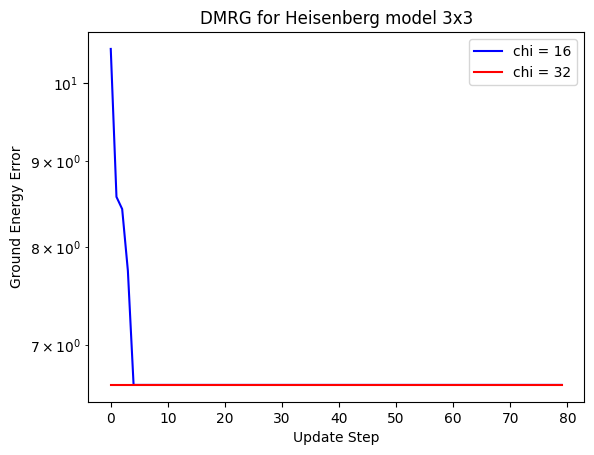

In [14]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

from ncon import ncon

##### Example 1: XX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 8
Nsites = 9

OPTS_numsweeps = 5 # number of DMRG sweeps
OPTS_dispon = 2 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 3 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

#### Define Hamiltonian MPO (quantum XX model)
chid = 2

s_P = np.sqrt(2)*np.array([[0, 0],[1, 0]])
s_M = np.sqrt(2)*np.array([[0, 1],[0, 0]])
s_X = np.array([[0, 1], [1, 0]])
s_Y = np.array([[0, -1j], [1j, 0]])
s_Z = np.array([[1, 0], [0,-1]])
s_I = np.array([[1, 0], [0, 1]])
""""
M = np.zeros([4,4,chid,chid]);
M[0,0,:,:] = sI; M[3,3,:,:] = sI
M[0,1,:,:] = sM; M[1,3,:,:] = sP
M[0,2,:,:] = sP; M[2,3,:,:] = sM
ML = np.array([1,0,0,0]).reshape(4,1,1) #left MPO boundary
MR = np.array([0,0,0,1]).reshape(4,1,1) #right MPO boundary
"""

M = np.zeros([11,11, chid, chid])
M[0,0,:,:] = s_I
M[0,1,:,:] = 0.5*s_X
M[0,5,:,:] = 0.5*s_Y
M[0,8,:,:] = s_Z

M[1,10,:,:] = s_X
M[3,10,:,:] = s_X
M[4,10,:,:] = s_Y
M[6,10,:,:] = s_Y
M[7,10,:,:] = s_Z
M[9,10,:,:] = s_Z
M[10,10,:,:] = s_I

ML = np.array([1,0,0,0,0,0,0,0,0,0,0]).reshape(11,1,1)
MR = np.array([0,0,0,0,0,0,0,0,0,0,1]).reshape(11,1,1)



#### Initialize MPS tensors
A = [0 for x in range(Nsites)]
A[0] = np.random.rand(1,chid,min(chi,chid))
for k in range(1,Nsites):
    A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(Nsites-k-1)))

#### Do DMRG sweeps (2-site approach)
En1, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon,
                                 updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

#### Increase bond dim and reconverge
chi = 32
En2, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, 
                                updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

#### Compare with exact results (computed from free fermions)
H = np.diag(np.ones(Nsites-1),k=1) + np.diag(np.ones(Nsites-1),k=-1)
D = LA.eigvalsh(H)
EnExact = 2*sum(D[D < 0])

##### Plot results
plt.figure(1)
plt.yscale('log')
plt.plot(range(len(En1)), En1 - EnExact, 'b', label="chi = 16")
plt.plot(range(len(En2)), En2 - EnExact, 'r', label="chi = 32")
plt.legend()
plt.title('DMRG for Heisenberg model 3x3')
plt.xlabel('Update Step')
plt.ylabel('Ground Energy Error')
plt.show()

#### Compute 2-site reduced density matrices, local energy profile
rhotwo = [0 for x in range(Nsites-1)]
hamloc = (np.real(np.kron(s_X,s_X) + np.kron(s_Y,s_Y))).reshape(2,2,2,2)
Enloc = np.zeros(Nsites-1)
for k in range(Nsites-1):
    rhotwo[k] = ncon([A[k],np.conj(A[k]),A[k+1],np.conj(A[k+1]),sWeight[k+2],
                     sWeight[k+2]],[[1,-3,2],[1,-1,3],[2,-4,4],[3,-2,5],[4,6],[5,6]])
    Enloc[k] = ncon([hamloc,rhotwo[k]],[[1,2,3,4],[1,2,3,4]])

(2, 2, 1)


1.0